# Insper - PADS -  Atividade Integradora

## Computação para Ciência de Dados - Processamento dos dados
Autores: 
- Fernando Travaglini (fernandotbl@al.insper.edu.br)

- Viviane Sanchez (vivianecs2@al.insper.edu.br)

Para visualizar o índice, é indicada a instalação do add-in [jupyterlab-toc](https://github.com/jeffjjohnston/RStudioConsoleRender).

# Introdução

O intuito deste trabalho é preparar e analisar dados de entrevistas de uma pesquisa de satisfação de prestação de Serviço Móvel pessoal. Posteriormente, serão aplicados modelos preditivos em R para criar um classificador de satisfação (alta ou baixa) de clientes. A variável resposta é a J1 - Nível de satisfação geral do entrevistado com a prestadora citada, levando em conta toda a experiência.

A base de dados utilizada está disponível [neste link](http://dados.gov.br/dataset/banco-de-dados-da-pesquisa-telefonia-movel-pre-paga).

## Objetivo

Preparar, organizar e analisar graficamente os dados para modelagem preditiva, principalmente com as bibliotecas [Pandas](https://pandas.pydata.org) e [Matplotlib](https://matplotlib.org).

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandasql
%matplotlib inline

## Dados

Como o pandas nativo não lê arquivos ODS, utilizou-se uma biblioteca específica.

In [2]:
raw = read_ods('data/BD_PRE.ods', sheet = 1)

In [3]:
bd_pre = raw.copy()

Após a leitura é possível ter uma ideia do conteúdo e formato das variáveis presentes na base de dados:

In [4]:
bd_pre.head()

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,999999.0,98.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,999999.0,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.0,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.0,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,999999.0,1.0,7.0,3.0,NaN,0.087025


In [5]:
bd_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148016 entries, 0 to 148015
Data columns (total 54 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   IDTNS      148016 non-null  float64
 1   TIPO       148016 non-null  object 
 2   OPERADORA  148016 non-null  object 
 3   ESTADO     148016 non-null  object 
 4   DATA       148016 non-null  object 
 5   ANO_BASE   148016 non-null  float64
 6   Q1         148016 non-null  float64
 7   Q2         148016 non-null  float64
 8   Q3         148016 non-null  float64
 9   Q4         148016 non-null  float64
 10  Q5         148016 non-null  float64
 11  Q6         148016 non-null  float64
 12  Q7         148016 non-null  float64
 13  Q8         148016 non-null  float64
 14  Q8a        148016 non-null  float64
 15  Q9         148016 non-null  float64
 16  J1         148016 non-null  float64
 17  B1_1       148016 non-null  float64
 18  B1_2       148016 non-null  float64
 19  C1_1       148016 non-n

# Organização e limpeza

Antes de manipular a base, foi consultada a documentação para entender melhor cada questão. A seguir um resumo.

## Tipos de variáveis

* Tipo 1: **1 = Sim ou 2 = Não**
    - Colunas: Q1, Q3, Q4, Q5, D1, F1, F3, F5, I1 e I2
       
    
* Tipo 2: variáveis medidas em uma escala de percepção de qualidade, que varia de **0 (Péssimo) a 10 (Excelente), ou 99 (Não Sabe, Não Responde)**
   - Colunas: B1 (B1_1 e B1_2), C1 (C1_1 e C1_2), D2 (D2_1 à D2_3), E1 (E1_1 à E1_3), A2 (A2_1 à A2_3), A3, A4, A5, F2, F4, F6 
   

* Tipo 3: variáveis que não possuem opções de escolha, apenas entrada direta de informações
    - Colunas: Q8, H0, H1 e H2
    
    
* Tipo 4: variáveis que possuem suas opções específicas diretamente após sua definição
    - As variáveis Q2, H2 e I1 possuem opções de resposta diferentes para os questionários ao longo dos anos e estarão devidamente indicadas.
    - As variáveis H0 e I2 foram acrescentadas a partir da pesquisa do ano de 201

## Itens da pesquisa

- Q: Perguntas
- A: Canais de Atendimento
- B: Oferta e Contratação
- C: Funcionamento de Voz
- D: Funcionamento de Dados (3G/4G)
- E: Recarga
- F: Capacidade de Resolução
- G: Competição
- H: Perfil Sócio demográfico
- I: Autorização para identificação

## Limpeza da base

### Ajuste de datas

Como a base é muito grande, o ajuste do formato da data na leitura pode sobrecarregar ou deixar ainda mais demorado o processo de leitura. Portanto o ajuste é feito após a base ser carregada no pandas.

In [6]:
bd_pre['DATA'] = pd.to_datetime(bd_pre['DATA'], format='%Y-%m-%d')

In [7]:
bd_pre['ANO_BASE'] = bd_pre['ANO_BASE'].astype(int)

In [8]:
bd_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148016 entries, 0 to 148015
Data columns (total 54 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   IDTNS      148016 non-null  float64       
 1   TIPO       148016 non-null  object        
 2   OPERADORA  148016 non-null  object        
 3   ESTADO     148016 non-null  object        
 4   DATA       148016 non-null  datetime64[ns]
 5   ANO_BASE   148016 non-null  int64         
 6   Q1         148016 non-null  float64       
 7   Q2         148016 non-null  float64       
 8   Q3         148016 non-null  float64       
 9   Q4         148016 non-null  float64       
 10  Q5         148016 non-null  float64       
 11  Q6         148016 non-null  float64       
 12  Q7         148016 non-null  float64       
 13  Q8         148016 non-null  float64       
 14  Q8a        148016 non-null  float64       
 15  Q9         148016 non-null  float64       
 16  J1         148016 no

### Padronização

Como a pesquisa foi realizada em momentos diferentes, algumas respostas mudam ao longo dos anos. Para modelar, é necessário padronizar essas respostas.

- Q2 - Área de trabalho do entrevistado:

In [9]:
bd_pre.Q2.unique()

array([2., 7.])

Segundo a documentação, 7 é a resposta do ano 2015 e corresponde a "Nenhum dos lugares informados". Pode, portanto, ser substituída por 2, que representa a mesma coisa nos anos subsequentes.

In [10]:
bd_pre.Q2.replace(7,2, inplace = True)

- H2 - Faixa de renda

In [11]:
bd_pre.H2.describe()

count    148016.000000
mean     254717.217767
std      434030.357299
min         100.000000
25%        1000.000000
50%        1800.000000
75%      999998.000000
max      999999.000000
Name: H2, dtype: float64

A diferença está apenas nas respostas não dadas: 999997, 999998 - sem renda/não sabe, e 999999 - recusa. Nesse primeiro momento, serão substituídas por NaN. para avaliar a distribuição da amostra sem esses valores.

(O comentário ao lado de cada linha representa a média quando o valor é substituído por 0)

In [12]:
bd_pre.H2.replace([999997,999998], np.nan, inplace = True) #0: média 1540
bd_pre.H2.replace([999999], np.nan, inplace = True) #tudo NA: média 1965 +-3718

In [13]:
bd_pre.H2.describe()

count    110531.000000
mean       1965.888927
std        3718.072973
min         100.000000
25%         900.000000
50%        1200.000000
75%        2000.000000
max      400000.000000
Name: H2, dtype: float64

Como alguns modelos não aceitam valores faltantes, todos eles serão susbtituídos por 0. Como o valor mínimo é 100, ainda é possível identificar quem não quis compartilhar essa informação.

In [14]:
bd_pre.H2.fillna(0, inplace = True)

- H2a - Faixa de renda vs Salário mínimo

In [15]:
bd_pre.H2a.describe()

count    148016.000000
mean     128075.130276
std      334161.996326
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max      999998.000000
Name: H2a, dtype: float64

Antes de tratar os casos não respondidos dessa questão, podemos extrair informações para a pergunta anterior. A seguir, as pessoas que não informaram a renda, mas informaram a faixa:

In [16]:
bd_pre[['H2','H2a']][bd_pre['H2'] == 0].groupby(['H2a']).count()

,H2
H2a,
1.0,6298
2.0,1268
3.0,438
4.0,197
5.0,156
98.0,3987
99.0,6185
999998.0,18956


In [17]:
(6298+1268+438+197+156)/148016*100

5.646011242027889

6% da base pode ter a informação de renda preenchida pela faixa. Para isso, será criada uma nova coluna combinando os dados das duas colunas mais adiante.

Vale observar também se existem pessoas que não informaram a faixa, mas informaram a renda.

In [18]:
bd_pre[['H2','H2a','ANO_BASE']][bd_pre.H2a.isna()]

,H2,H2a,ANO_BASE


Como a resposta 999998 não está na documentação da questão H2a, será considerada como "Não respondeu", análoga ao item anterior.

Assim como no item H2, todos que não informaram a renda terão o valor substituído por 0: Faixa não informada

In [19]:
bd_pre.H2a.replace([98,99,999998,999999],0,inplace = True)

In [20]:
#bd_pre.ANO_BASE.unique()

In [21]:
#conditions = [bd_pre.ANO_BASE <= 2016, bd_pre.ANO_BASE >= 2017]

In [22]:
#choice_0 = [bd_pre.H2a.replace([98,99],0, inplace = True),bd_pre.H2a.replace([999998], np.nan, inplace = True)] np.nan
#choice_na = [bd_pre.H2a.replace([999998, 999998], np.nan, inplace = True), bd_pre.H2a.replace([99], np.nan, inplace = True)] #np.nan

In [23]:
#np.select(conditions,choice_0)
#np.select(conditions,choice_na)

In [24]:
bd_pre.H2a.value_counts()

1.0    65537
2.0    32981
0.0    29128
3.0    12926
4.0     4143
5.0     3301
Name: H2a, dtype: int64

In [25]:
bd_pre.H2a.describe()

count    148016.000000
mean          1.373865
std           1.112607
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: H2a, dtype: float64

A seguir, observa-se a distribuição das respostas por ano e quantas pessoas informaram ou não a renda na questão H2.

In [26]:
pd.crosstab(index=bd_pre['ANO_BASE'], columns=bd_pre['H2a'])

H2a,0.0,1.0,2.0,3.0,4.0,5.0
ANO_BASE,,,,,,
2015,8889,10297,13361,7719,1848,1856
2016,5884,15446,5921,1475,653,423
2017,4183,17712,6120,1619,656,376
2018,5698,11885,4229,1190,559,412
2019,4474,10197,3350,923,427,234


In [27]:
pd.crosstab(index=bd_pre['ANO_BASE'], columns=bd_pre['H2']==0)

H2,False,True
ANO_BASE,,
2015,35081,8889
2016,23918,5884
2017,25213,5453
2018,14416,9557
2019,11903,7702


Considerando as duas tabelas acima (coluna 0 da primeira e coluna True da segunda), nota-se que nos dois primeiros anos da pesquisa, quem não informou a renda também não informou a faixa. Como o número de respostas que podem ser completadas é pequeno, será mantida a resposta "0" para quem não compartilhou essa informação.

- H2b - Combinação das colunas H2 e H2a para estimar a renda.

Na documentação, constam as faixas e valores por salário mínimo. No entanto, as informações vão até 2017, enquanto os dados vão até 2019. Para contornar essa falta de informação, serão puxados os dados  sobre valores nominais do salário mínimo. Idealmente, esses dados estariam disponíveis no [Portal Brasileiro de Dados Abertos](http://www.dados.gov.br/dataset/salario-minimo/resource/8b9ccf0d-aff2-499f-8363-0fcd44ec68b3), mas o link parece não estar funcionando, e a última atualização dos dados foi em 2016.

Felizmente, essa informação está disponível em csv no [IPEADATA](http://www.ipeadata.gov.br/Default.aspx), alimentada pelo Ministério do Trabalho e Emprego.

In [28]:
sm = pd.read_csv('data/ipeadata[15-04-2020-08-50].csv', usecols = [0,1], names = ['Data','Valor'], skiprows = 1, dtype = {'Data': object})

In [29]:
sm.head()

,Data,Valor
0,1940.07,8.727273e-14
1,1940.08,8.727273e-14
2,1940.09,8.727273e-14
3,1940.10,8.727273e-14
4,1940.11,8.727273e-14


In [30]:
sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    966 non-null    object 
 1   Valor   966 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.2+ KB


In [31]:
sm[['Ano','Mes']] = sm.Data.str.split('.', expand = True)

In [32]:
sm.head()

,Data,Valor,Ano,Mes
0,1940.07,8.727273e-14,1940,07
1,1940.08,8.727273e-14,1940,08
2,1940.09,8.727273e-14,1940,09
3,1940.10,8.727273e-14,1940,10
4,1940.11,8.727273e-14,1940,11


In [33]:
sm.Ano = sm.Ano.astype(int)

Como o valor é o mesmo para todos os anos, pode-se agrupar a base:

In [34]:
sm_ano = sm.groupby('Ano').mean()

Dessa forma, temos os mesmos valores que constam na documentação:

In [35]:
sm_ano.tail(6)

,Valor
Ano,
2015,788.0
2016,880.0
2017,937.0
2018,954.0
2019,998.0
2020,1044.5


Abaixo, os valores que podem ser substituídos:

In [36]:
pd.crosstab(index=bd_pre['ANO_BASE'], columns=bd_pre['H2a'][bd_pre['H2'] == 0])

H2a,0.0,1.0,2.0,3.0,4.0,5.0
ANO_BASE,,,,,,
2015,8889,0,0,0,0,0
2016,5884,0,0,0,0,0
2017,4183,832,264,94,43,37
2018,5698,2896,584,207,93,79
2019,4474,2570,420,137,61,40


Como a divisão das faixas da questão H2a variam ano a ano, e as informações que podem ser substituídas começam em 2017, será adotada a divisão de para esses dados. Além disso, será considerado o valor médio de cada faixa, exceto pela primeira e pela última. Como as faixas de 2015 são diferentes, esse ano será tratado separadamente.

In [37]:
faixas = {0:0, 1:2, 2:(2+4)/2, 3:(4+6)/2, 4:(6+10)/2, 5:10} #faixa : múltiplos do salário mínimo
faixas

{0: 0, 1: 2, 2: 3.0, 3: 5.0, 4: 8.0, 5: 10}

In [38]:
faixas_15 = {0:0, 1:1, 2:(1+2)/2, 3:(3+4)/2, 4:(4+6)/2, 5:(6+10)/2, 6:10} 
faixas_15

{0: 0, 1: 1, 2: 1.5, 3: 3.5, 4: 5.0, 5: 8.0, 6: 10}

In [39]:
bd_pre['sm'] = bd_pre.ANO_BASE.map(sm_ano.Valor) #busca o valor de salário mínimo para cada ano

In [40]:
bd_pre.head()

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO,sm
0,576.0,PRE,OI,RN,2019-08-07,2019,1.0,2.0,1.0,1.0,...,EXTREMOZ,2403608,1.0,0.0,0.0,4.0,3.0,NaN,0.534404,998.0
1,971.0,PRE,CLARO,RN,2019-08-07,2019,1.0,2.0,1.0,1.0,...,PARNAMIRIM,2403251,2.0,0.0,1.0,2.0,1.0,NaN,0.626276,998.0
2,1200.0,PRE,TIM,SE,2019-08-07,2019,1.0,2.0,1.0,1.0,...,ARACAJU,2800308,1.0,1300.0,1.0,6.0,1.0,NaN,0.120366,998.0
3,1305.0,PRE,OI,GO,2019-08-07,2019,1.0,2.0,1.0,1.0,...,NIQUELANDIA,5214606,4.0,998.0,1.0,6.0,1.0,NaN,0.613932,998.0
4,1349.0,PRE,TIM,TO,2019-08-07,2019,1.0,2.0,1.0,1.0,...,PALMAS,1721000,1.0,0.0,1.0,7.0,3.0,NaN,0.087025,998.0


In [41]:
conditions = [bd_pre.ANO_BASE == 2015, bd_pre.ANO_BASE >= 2016]

In [42]:
choice = [bd_pre.H2a.map(faixas_15), bd_pre.H2a.map(faixas)]

In [43]:
bd_pre['sm_mult'] = np.select(conditions,choice)

In [44]:
bd_pre['H2b'] = np.where(bd_pre.H2 !=0 , bd_pre.H2, bd_pre['sm_mult'].mul(bd_pre.sm)) #multiplica a faixa por valor do salário mínimo

In [45]:
bd_pre.head()

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,H1,H2,H2a,H3,I1,I2,PESO,sm,sm_mult,H2b
0,576.0,PRE,OI,RN,2019-08-07,2019,1.0,2.0,1.0,1.0,...,1.0,0.0,0.0,4.0,3.0,NaN,0.534404,998.0,0.0,0.0
1,971.0,PRE,CLARO,RN,2019-08-07,2019,1.0,2.0,1.0,1.0,...,2.0,0.0,1.0,2.0,1.0,NaN,0.626276,998.0,2.0,1996.0
2,1200.0,PRE,TIM,SE,2019-08-07,2019,1.0,2.0,1.0,1.0,...,1.0,1300.0,1.0,6.0,1.0,NaN,0.120366,998.0,2.0,1300.0
3,1305.0,PRE,OI,GO,2019-08-07,2019,1.0,2.0,1.0,1.0,...,4.0,998.0,1.0,6.0,1.0,NaN,0.613932,998.0,2.0,998.0
4,1349.0,PRE,TIM,TO,2019-08-07,2019,1.0,2.0,1.0,1.0,...,1.0,0.0,1.0,7.0,3.0,NaN,0.087025,998.0,2.0,1996.0


In [46]:
bd_pre.H2b.describe()

count    148016.000000
mean       1610.009762
std        3330.823009
min           0.000000
25%         500.000000
50%        1000.000000
75%        2000.000000
max      400000.000000
Name: H2b, dtype: float64

In [47]:
bd_pre.H2.describe()

count    148016.000000
mean       1468.028247
std        3324.752839
min           0.000000
25%           0.000000
50%         998.000000
75%        1800.000000
max      400000.000000
Name: H2, dtype: float64

Com a coluna criada, pode-se remover as colunas auxiliares criadas:

In [48]:
bd_pre.drop(['sm','sm_mult'], axis = 1, inplace = True)

In [49]:
bd_pre.head()

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO,H2b
0,576.0,PRE,OI,RN,2019-08-07,2019,1.0,2.0,1.0,1.0,...,EXTREMOZ,2403608,1.0,0.0,0.0,4.0,3.0,NaN,0.534404,0.0
1,971.0,PRE,CLARO,RN,2019-08-07,2019,1.0,2.0,1.0,1.0,...,PARNAMIRIM,2403251,2.0,0.0,1.0,2.0,1.0,NaN,0.626276,1996.0
2,1200.0,PRE,TIM,SE,2019-08-07,2019,1.0,2.0,1.0,1.0,...,ARACAJU,2800308,1.0,1300.0,1.0,6.0,1.0,NaN,0.120366,1300.0
3,1305.0,PRE,OI,GO,2019-08-07,2019,1.0,2.0,1.0,1.0,...,NIQUELANDIA,5214606,4.0,998.0,1.0,6.0,1.0,NaN,0.613932,998.0
4,1349.0,PRE,TIM,TO,2019-08-07,2019,1.0,2.0,1.0,1.0,...,PALMAS,1721000,1.0,0.0,1.0,7.0,3.0,NaN,0.087025,1996.0


- I1 - Autorização para identificação das respostas para a empresa que solicitou a pesquisa (2015) ou para a Anatel (a partir de 2016)

In [50]:
pd.crosstab(index=bd_pre['ANO_BASE'], columns=bd_pre['I1'])

I1,1.0,2.0,3.0
ANO_BASE,,,
2015,32443,11527,0
2016,23177,6625,0
2017,24494,6172,0
2018,17946,6027,0
2019,16164,213,3228


Na documentação, consta que a resposta 3 é correspondente a "Não sabe". Como é uma amostra pequena, será mantida na base, mas com o valor 0.

In [51]:
bd_pre['I1'].replace(3,0, inplace = True)

### Tratamento de NAs

Colunas com valores faltando:

In [52]:
colunas_na = bd_pre.columns[bd_pre.isna().any()].sort_values()

In [53]:
colunas_na

Index(['A1_1', 'A1_2', 'A1_3', 'A1_4', 'A2_1', 'A2_2', 'A2_3', 'A3', 'A4',
       'A5', 'D2_1', 'D2_2', 'D2_3', 'F2', 'F4', 'F5', 'F6', 'G1', 'H3', 'I2'],
      dtype='object')

Valores de resposta em cada questão:

In [54]:
for col in colunas_na:
    print(col, bd_pre[col].unique())

A1_1 [nan  1.]
A1_2 [nan  2.]
A1_3 [ 3. nan]
A1_4 [nan 97.]
A2_1 [nan  0.  8.  3. 10.  9.  5.  2.  7.  4.  1. 99.  6.]
A2_2 [nan 10.  6.  5.  9.  8.  0.  3.  1.  2.  7.  4. 99.]
A2_3 [nan 10.  9.  5.  7.  8.  4.  6.  1.  0.  2. 99.  3.]
A3 [nan 10.  6.  8.  9.  5.  4.  7.  1.  0.  2.  3. 99.]
A4 [nan  8.  4.  9. 10.  3.  7.  5.  0.  2.  6.  1. 99.]
A5 [10. nan  8.  3.  6.  7.  9.  1.  5.  0.  4. 99.  2.]
D2_1 [nan 10.  9.  7.  5.  8.  3.  6.  4.  2.  0.  1. 99.]
D2_2 [nan 10.  9.  7.  8.  5.  4.  6.  3.  0.  2.  1. 99.]
D2_3 [nan 10.  9.  7.  4.  6.  8.  2.  5.  0.  1.  3. 99.]
F2 [ 0. 10. nan  6.  8.  3.  1.  2.  4.  5.  7.  9. 99.]
F4 [10. nan  6.  5.  3.  0.  7.  1.  4.  8.  9.  2. 99.]
F5 [nan  2.  1.]
F6 [nan 10.  0.  9.  7.  6.  3.  8.  4.  1.  5.  2. 99.]
G1 [nan  1.  2.  3.]
H3 [ 4.  2.  6.  7.  5.  3. 99.  1.  9.  8. nan]
I2 [nan  2.  1.]


- Perguntas com resposta Sim/Não:

Para otimizar, foi criada uma função para substituir os valores conforme cada questão.

In [55]:
def na_sim_nao(col, valor_sim, valor_nao = 'na', fill_na = 2):
    bd_pre[col].replace(valor_sim,1,inplace = True)
    bd_pre[col].fillna(fill_na, inplace = True)
    if valor_nao != 'na':
        bd_pre[col].replace(valor_nao, 2,inplace = True)

In [56]:
for i in range(1,5):
    #print('A1_'+str(i), bd_pre['A1_'+str(i)].unique())
    print('A1_'+str(i)+'\n', bd_pre['A1_'+str(i)].value_counts()) #respostas 'Sim'
    print('')

A1_1
 1.0    90187
Name: A1_1, dtype: int64

A1_2
 2.0    32752
Name: A1_2, dtype: int64

A1_3
 3.0    22512
Name: A1_3, dtype: int64

A1_4
 97.0    42892
Name: A1_4, dtype: int64



In [57]:
na_sim_nao('A1_1',1)
na_sim_nao('A1_2',2)
na_sim_nao('A1_3',3)
na_sim_nao('A1_4',97)

In [58]:
#conferência dos valores substituídos.
for i in range(1,5):
    #print('A1_'+str(i), bd_pre['A1_'+str(i)].unique())
    print('A1_'+str(i)+'\n', bd_pre['A1_'+str(i)].value_counts())
    print('')

A1_1
 1.0    90187
2.0    57829
Name: A1_1, dtype: int64

A1_2
 2.0    115264
1.0     32752
Name: A1_2, dtype: int64

A1_3
 2.0    125504
1.0     22512
Name: A1_3, dtype: int64

A1_4
 2.0    105124
1.0     42892
Name: A1_4, dtype: int64



- F5 - A questão F5 depende da resposta da pergunta D1:

"Descreve se o usuário entrou em contato com a prestadora citada para falar sobre problemas na internet 3G/4G nos 6 meses anteriores à pesquisa, apenas para os que responderam SIM para a utilização da internet móvel (D1)"

D1: Descreve se o usuário utilizou o serviço de internet 3G/4G seis meses anteriores à pesquisa."

Entende-se, portanto que quem respondeu "não" à pergunta D1, também não entrou em contato para falar sobre esse assunto. Os valores faltantes serão substituídos por 2, que significa "Não"

In [59]:
print(bd_pre.D1.value_counts())
bd_pre.D1.value_counts().sum()

1.0    81989
2.0    66027
Name: D1, dtype: int64


148016

In [60]:
bd_pre[['D1','F5']]

,D1,F5
0,2.0,NaN
1,1.0,2.0
2,2.0,NaN
3,1.0,2.0
4,2.0,NaN
...,...,...
148011,2.0,NaN
148012,1.0,2.0
148013,1.0,1.0
148014,2.0,NaN


In [61]:
bd_pre['F5'][bd_pre['D1']==2].unique()

array([nan])

In [62]:
bd_pre.F5.fillna(2,inplace = True)

In [63]:
bd_pre.F5.value_counts()

2.0    126297
1.0     21719
Name: F5, dtype: int64

- I2 - Assim como na questão I1, os valores faltantes serão padronizados para 0 - "Não sabe", para uma análise preliminar.

In [64]:
pd.crosstab(index=bd_pre['ANO_BASE'], columns=bd_pre['I2'])

I2,1.0,2.0
ANO_BASE,,
2016,24855,4947
2017,26061,4605
2018,18342,5631


In [65]:
pd.crosstab(index=bd_pre['ANO_BASE'], columns=bd_pre.I2.fillna(0))

I2,0.0,1.0,2.0
ANO_BASE,,,
2015,43970,0,0
2016,0,24855,4947
2017,0,26061,4605
2018,0,18342,5631
2019,19605,0,0


Conforme consta na documetnação, essa pergunta não foi realizada nem em 2015, e aparentemente nem em 2019. Uma solução seria replicar a resposta da coluna I1, visto que as perguntas são parecidas. Para isso, é necessário avaliar se as respostas que foram dadas são iguais nas duas colunas.

In [66]:
bd_pre.I2[bd_pre.I1 == 1].fillna(0).value_counts()

1.0    62806
0.0    48607
2.0     2811
Name: I2, dtype: int64

In [67]:
bd_pre.I2[bd_pre.I1 == 2].fillna(0).value_counts()

2.0    12372
0.0    11740
1.0     6452
Name: I2, dtype: int64

Como é observado, podem existir respostas para as perguntas I1 diferentes da I2, portanto, a melhor alternativa é substituir o valor faltante por 0: "Não sabe"

In [68]:
bd_pre.I2.fillna(0, inplace = True)

- Perguntas com respostas contínuas que possuem NA na resposta:

In [69]:
colunas_na = bd_pre.columns[bd_pre.isna().any()].sort_values()
colunas_na

Index(['A2_1', 'A2_2', 'A2_3', 'A3', 'A4', 'A5', 'D2_1', 'D2_2', 'D2_3', 'F2',
       'F4', 'F6', 'G1', 'H3'],
      dtype='object')

In [70]:
col_na = colunas_na #.drop(['H2','H2a']) #tirando variáveis de renda
col_na

Index(['A2_1', 'A2_2', 'A2_3', 'A3', 'A4', 'A5', 'D2_1', 'D2_2', 'D2_3', 'F2',
       'F4', 'F6', 'G1', 'H3'],
      dtype='object')

Para todas as perguntas, 99 significa 'Não sabe' ou 'Não respondeu'. Portanto, os NAs serão substituídos por 99.

In [71]:
for col in col_na:
    bd_pre[col].fillna(99, inplace = True)

Com isso, todos os valores faltantes foram eliminados da base:

In [72]:
bd_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148016 entries, 0 to 148015
Data columns (total 55 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   IDTNS      148016 non-null  float64       
 1   TIPO       148016 non-null  object        
 2   OPERADORA  148016 non-null  object        
 3   ESTADO     148016 non-null  object        
 4   DATA       148016 non-null  datetime64[ns]
 5   ANO_BASE   148016 non-null  int64         
 6   Q1         148016 non-null  float64       
 7   Q2         148016 non-null  float64       
 8   Q3         148016 non-null  float64       
 9   Q4         148016 non-null  float64       
 10  Q5         148016 non-null  float64       
 11  Q6         148016 non-null  float64       
 12  Q7         148016 non-null  float64       
 13  Q8         148016 non-null  float64       
 14  Q8a        148016 non-null  float64       
 15  Q9         148016 non-null  float64       
 16  J1         148016 no

Para facilitar a vizualização, as respostas não dadas (99) de todas as perguntas do Tipo 2 serão substituídas por -1.

In [73]:
tipo_2 = ['B1_1','B1_2','C1_1','C1_2','D2_1','D2_3','E1_1','E1_2','E1_3','A2_1','A2_2','A2_3','A3','A4','A5','F2','F4','F6']

In [74]:
for col in tipo_2:
    bd_pre[col].replace(99,-1,inplace = True)

Além das perguntas tipo 2, algumas outras questões possuem valores "não informados". Esses casos serão tratados a seguir:

- Q8 - Idade do entrevistado

In [75]:
bd_pre.Q8.describe()

count    148016.00000
mean       2428.38202
std       48844.13112
min          18.00000
25%          27.00000
50%          35.00000
75%          45.00000
max      999999.00000
Name: Q8, dtype: float64

Como algumas pessoas não identificaram a idade, esse valor será primeiramente substituído por NaN, para que a média real da base seja revelada.

In [76]:
bd_pre.Q8.replace(999999,np.nan, inplace = True)

In [77]:
bd_pre.Q8.describe()

count    147662.000000
mean         36.839180
std          12.598699
min          18.000000
25%          27.000000
50%          35.000000
75%          45.000000
max          98.000000
Name: Q8, dtype: float64

- Q8a - Faixa etária

In [78]:
bd_pre.Q8a.describe()

count    148016.000000
mean          5.440615
std           1.741827
min           3.000000
25%           4.000000
50%           5.000000
75%           7.000000
max           9.000000
Name: Q8a, dtype: float64

Aparentemente não houve nenhuma resposta em que não foi informada a faixa etária. Também não houve nenhum entrevistado com menos de 18 anos.

In [79]:
pd.crosstab(index=bd_pre['ANO_BASE'], columns=bd_pre['Q8a'])

Q8a,3.0,4.0,5.0,6.0,7.0,8.0,9.0
ANO_BASE,,,,,,,
2015,7385,8554,6610,6098,8476,6427,420
2016,5299,5745,4374,4044,5681,4394,265
2017,5676,6159,4588,4290,5659,4043,251
2018,4124,4582,3552,3418,4626,3419,252
2019,3400,3779,2909,2815,3652,2849,201


In [80]:
bd_pre.Q8a.value_counts()

4.0    28819
7.0    28094
3.0    25884
5.0    22033
8.0    21132
6.0    20665
9.0     1389
Name: Q8a, dtype: int64

In [81]:
bd_pre.Q8a[bd_pre.Q8.isna()].value_counts()

7.0    72
4.0    67
8.0    56
6.0    53
5.0    45
3.0    43
9.0    18
Name: Q8a, dtype: int64

Como a informação da faixa etária está disponível em todos os casos, e o valor é pequeno considerando o tamaho da amostra, a resposta da idade Q8 será substituída pela média da faixa etária, conforme consta na documentação:

1. Menor de 16
2. De 16 a 17 anos
3. De 18 a 24 anos
4. De 25 a 30 anos
5. De 31 a 35 anos
6. De 36 a 40 anos
7. De 41 a 50 anos
8. De 51 a 70 anos
9. Mais de 70 anos

99 Recusa


In [82]:
idade_avg = {3:(18+24)/ 2 , 4:(25+30)/ 2 , 5:(31+35)/ 2, 6:(36+40)/ 2 , 7:(41+50)/ 2 , 8: (51+70)/2, 9: 70}

In [83]:
idade_avg

{3: 21.0, 4: 27.5, 5: 33.0, 6: 38.0, 7: 45.5, 8: 60.5, 9: 70}

Por fim, os valores NA da questão Q8 são substituídos com a média da idade de cada faixa.

In [84]:
bd_pre.Q8.describe()

count    147662.000000
mean         36.839180
std          12.598699
min          18.000000
25%          27.000000
50%          35.000000
75%          45.000000
max          98.000000
Name: Q8, dtype: float64

In [85]:
bd_pre.Q8.fillna(bd_pre.Q8a.map(idade_avg), inplace = True)

In [86]:
bd_pre.Q8.describe()

count    148016.000000
mean         36.846797
std          12.603448
min          18.000000
25%          27.000000
50%          35.000000
75%          45.000000
max          98.000000
Name: Q8, dtype: float64

Como é possível observar, a média final e desvio padrão da base sofreram uma alteração mínima (a média foi de 36.839180 para 36.846797).

- H0: Cidade

In [87]:
bd_pre.H0.value_counts()

                     43970
OUTRA                 3511
MANAUS                2955
RECUSA                2750
BOA VISTA             2527
                     ...  
ARAPIACA ALAGOAS         1
VILHANA RONDONIA         1
BVITÇOSA                 1
PLANATINA (GOIAS)        1
ITUMIARA                 1
Name: H0, Length: 11848, dtype: int64

Aparentemente, a maior ocorrência é "vazia". Nesses casos, será substituída por "OUTRA", como já consta na base.

In [88]:
bd_pre.H0.replace('','OUTRA', inplace = True)

In [89]:
bd_pre.H0.value_counts()

OUTRA                47481
MANAUS                2955
RECUSA                2750
BOA VISTA             2527
RIO BRANCO            2256
                     ...  
PERATRIX                 1
VILHANA RONDONIA         1
BVITÇOSA                 1
PLANATINA (GOIAS)        1
CAMPO ALEGRA             1
Name: H0, Length: 11847, dtype: int64

- COD_IBGE

In [90]:
bd_pre.COD_IBGE.value_counts()

           104438
9999999      2741
5300108      1256
1400100      1212
1302603      1192
            ...  
3120201         1
4306072         1
4319752         1
2402709         1
2924801         1
Name: COD_IBGE, Length: 3601, dtype: int64

Nos itens em que não há informação do código do IBGE será inserido o código 0.

In [91]:
bd_pre.COD_IBGE.replace('',0, inplace = True)

In [92]:
bd_pre.COD_IBGE.value_counts()

0          104438
9999999      2741
5300108      1256
1400100      1212
1302603      1192
            ...  
3120201         1
4306072         1
4319752         1
2402709         1
2924801         1
Name: COD_IBGE, Length: 3601, dtype: int64

### Distribuição das amostras

Com todas as transformações realizadas no item anterior, é possível ter uma ideia melhor da distribuição de cada coluna com valor numérico:

In [93]:
bd_pre.describe().T

,count,mean,std,min,25%,50%,75%,max
IDTNS,148016.0,1.799845e+07,2.149904e+07,378.000000,2.750190e+06,6.605928e+06,4.038988e+07,6.203986e+07
ANO_BASE,148016.0,2.016631e+03,1.394815e+00,2015.000000,2.015000e+03,2.017000e+03,2.018000e+03,2.019000e+03
Q1,148016.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Q2,148016.0,2.000000e+00,0.000000e+00,2.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
Q3,148016.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Q4,148016.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Q5,148016.0,1.029672e+00,1.696827e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
Q6,148016.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Q7,148016.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Q8,148016.0,3.684680e+01,1.260345e+01,18.000000,2.700000e+01,3.500000e+01,4.500000e+01,9.800000e+01


In [94]:
stats = bd_pre.describe().T.sort_values('std') #colunas organizadas em ordem crescente do desvio padrão

Colunas com desvio padrão nulo, ou seja, que possuem apenas uma resposta e, portanto, não vão influenciar os modelos, são removidas da base para otimizar o processamento.

In [95]:
valor_unico = stats[stats['std'] == 0].T.columns.sort_values().tolist()

In [96]:
valor_unico

['Q1', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7']

In [97]:
valor_unico.append('TIPO')
valor_unico

['Q1', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'TIPO']

In [98]:
#remover colunas
bd_pre.drop(valor_unico, axis = 1, inplace = True) 

In [99]:
bd_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148016 entries, 0 to 148015
Data columns (total 48 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   IDTNS      148016 non-null  float64       
 1   OPERADORA  148016 non-null  object        
 2   ESTADO     148016 non-null  object        
 3   DATA       148016 non-null  datetime64[ns]
 4   ANO_BASE   148016 non-null  int64         
 5   Q5         148016 non-null  float64       
 6   Q8         148016 non-null  float64       
 7   Q8a        148016 non-null  float64       
 8   Q9         148016 non-null  float64       
 9   J1         148016 non-null  float64       
 10  B1_1       148016 non-null  float64       
 11  B1_2       148016 non-null  float64       
 12  C1_1       148016 non-null  float64       
 13  C1_2       148016 non-null  float64       
 14  D1         148016 non-null  float64       
 15  D2_1       148016 non-null  float64       
 16  D2_2       148016 no

### Variável resposta

Como o objetivo é criar um classificador para as respotas da pergunta J1, primeiro serão analisadas as respostas faltantes (99):

In [100]:
(bd_pre[bd_pre['J1'] == 99].shape[0]/bd_pre.shape[0])*100

0.15741541454977842

Como apenas 0,15% da amostra não possui resposta, essas linhas serão removidas da base.

In [101]:
bd_pre['J1'].replace(99, np.nan, inplace = True)

In [102]:
bd_pre.dropna(subset = ['J1'], inplace = True)

In [103]:
bd_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147783 entries, 0 to 148015
Data columns (total 48 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   IDTNS      147783 non-null  float64       
 1   OPERADORA  147783 non-null  object        
 2   ESTADO     147783 non-null  object        
 3   DATA       147783 non-null  datetime64[ns]
 4   ANO_BASE   147783 non-null  int64         
 5   Q5         147783 non-null  float64       
 6   Q8         147783 non-null  float64       
 7   Q8a        147783 non-null  float64       
 8   Q9         147783 non-null  float64       
 9   J1         147783 non-null  float64       
 10  B1_1       147783 non-null  float64       
 11  B1_2       147783 non-null  float64       
 12  C1_1       147783 non-null  float64       
 13  C1_2       147783 non-null  float64       
 14  D1         147783 non-null  float64       
 15  D2_1       147783 non-null  float64       
 16  D2_2       147783 no

Por fim, será gerada uma nova coluna com a classificação conforme a nota:
**Alta**, para notas maiores ou iguais a 8, ou **baixa**.

In [104]:
bd_pre['Resposta'] = np.where(bd_pre.J1 >= 8, 'Alta', 'Baixa')

In [105]:
bd_pre.head()

,IDTNS,OPERADORA,ESTADO,DATA,ANO_BASE,Q5,Q8,Q8a,Q9,J1,...,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO,H2b,Resposta
0,576.0,OI,RN,2019-08-07,2019,1.0,60.5,8.0,1.0,0.0,...,2403608,1.0,0.0,0.0,4.0,0.0,0.0,0.534404,0.0,Baixa
1,971.0,CLARO,RN,2019-08-07,2019,1.0,56.0,8.0,1.0,10.0,...,2403251,2.0,0.0,1.0,2.0,1.0,0.0,0.626276,1996.0,Alta
2,1200.0,TIM,SE,2019-08-07,2019,1.0,40.0,6.0,2.0,4.0,...,2800308,1.0,1300.0,1.0,6.0,1.0,0.0,0.120366,1300.0,Baixa
3,1305.0,OI,GO,2019-08-07,2019,1.0,23.0,3.0,1.0,9.0,...,5214606,4.0,998.0,1.0,6.0,1.0,0.0,0.613932,998.0,Alta
4,1349.0,TIM,TO,2019-08-07,2019,1.0,21.0,3.0,1.0,6.0,...,1721000,1.0,0.0,1.0,7.0,0.0,0.0,0.087025,1996.0,Baixa


# Análise gráfica 

## Comparação do nível de satisfação

In [106]:
sns.set(style="ticks", palette="pastel")

Antes de iniciar as comparações, segue a distribuição da nota de avaliação:

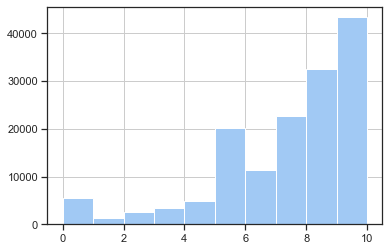

In [107]:
bd_pre.J1.hist()

Para ter uma ideia das avaliações, serão feitas comparações em percentual da resposta por operadora, estado e data da entrevista. Para facilitar, será criada uma função:

In [108]:
formatter = PercentFormatter()

In [109]:
def grafico_pct(col_name, group = 0):
    
    temp = pd.crosstab(index = bd_pre[col_name],columns = bd_pre['Resposta'])
    
    temp.div(temp.sum(axis = 1), axis = 0).mul(100).plot(kind='bar', stacked=False, zorder=3, figsize = (15,8), color =["g", "r"])
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(zorder=0)
    plt.legend(loc = 'upper right')

### Por Operadora

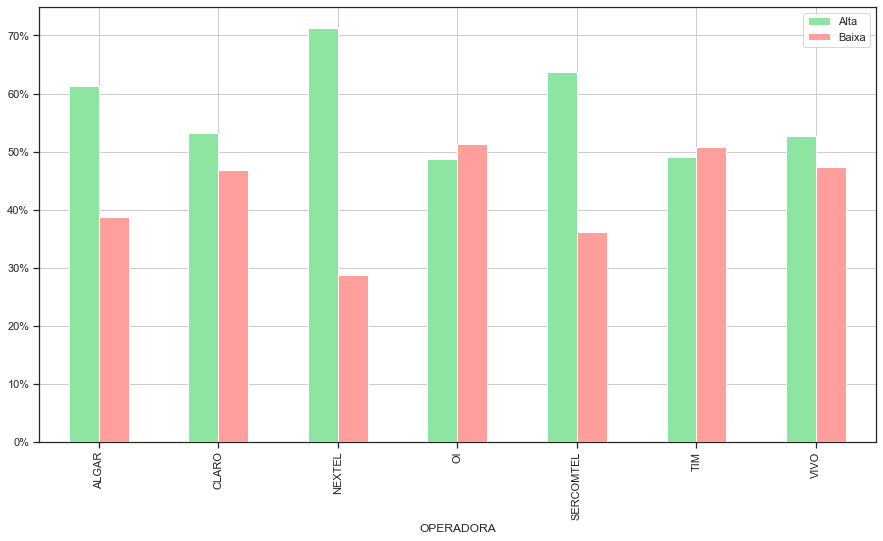

In [110]:
grafico_pct('OPERADORA')

Oi e Tim são as únicas operadoras com mais notas baixas do que altas, enquanto Nextel é a operadora com melhor avaliação.

### Por Região

- Estado

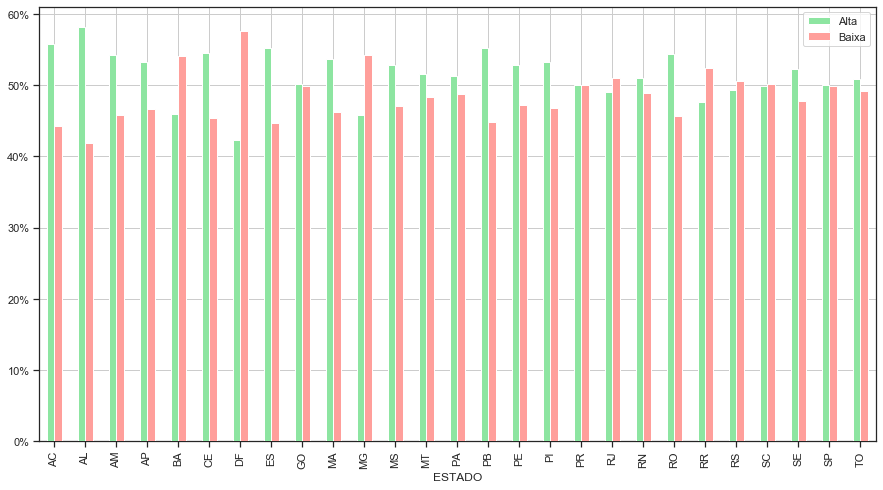

In [111]:
grafico_pct('ESTADO')

AL é o estado com melhor avaliação, enquanto DF é o de pior nota.

### Por Data

Busca de relações com dia da semana, mês e ano da entrevista em números absolutos.

Função para gerar os gráficos:

In [112]:
def analise_data(col_name, group = 0):
    week_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    
    if group == 'week_day':
        bd_pre[col_name] = bd_pre.DATA.dt.strftime('%A')
        bd_pre[col_name] = pd.Categorical(bd_pre[col_name], categories = week_days, ordered=True)
    elif group == 'month':
        bd_pre[col_name] = bd_pre.DATA.dt.strftime('%m')

    #bd_pre.groupby(col_name).count().sort_values(col_name)
    temp = pd.crosstab(index = bd_pre[col_name],columns = bd_pre['Resposta'])
    
    temp.plot(kind='bar', stacked=False, zorder=3, figsize = (15,8), color =["g", "r"])
    plt.grid(zorder=0)
    plt.legend(loc = 'upper right')

- Dia da semana

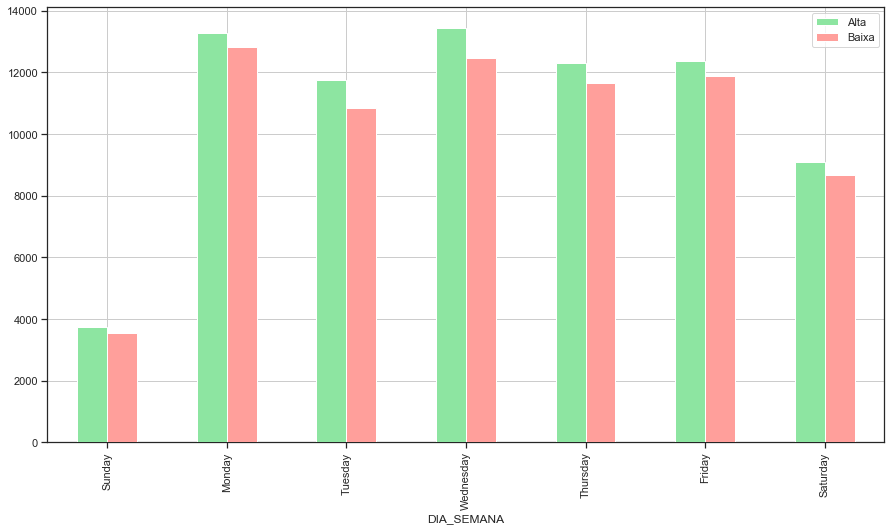

In [113]:
analise_data('DIA_SEMANA','week_day')

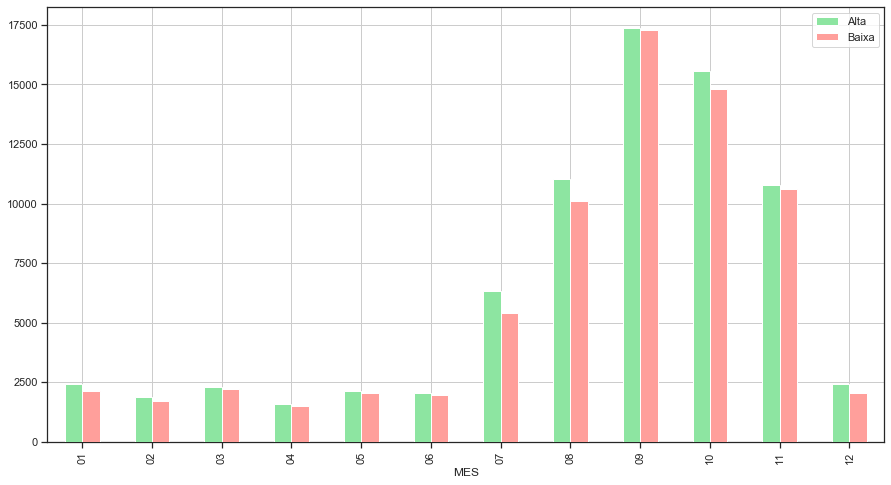

In [114]:
analise_data('MES','month')

Aparentemente existe uma concentração da quantidade de entrevistados no segundo semestre do ano, exceto pelo último mês.

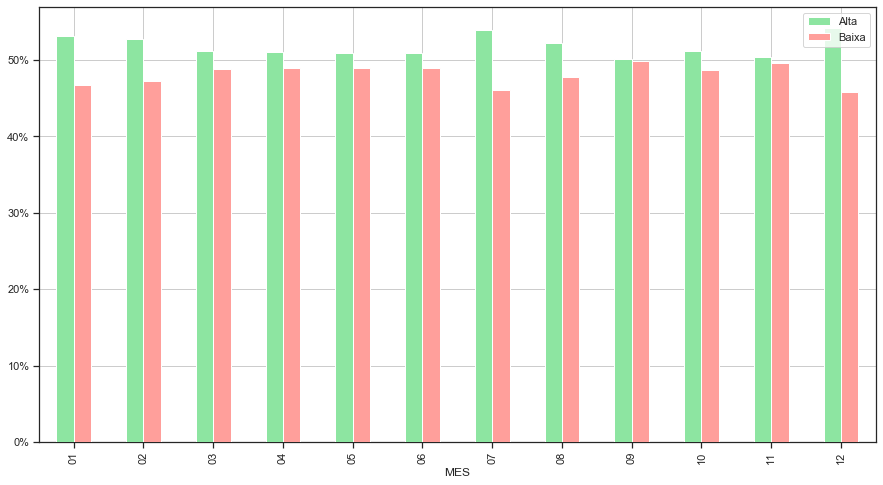

In [115]:
grafico_pct('MES')

In [116]:
bd_pre.MES = bd_pre.MES.astype(int)

Olhando a distribuição percentual, é possível ver melhor a diferença entre as avaliações para cada mês.

- Anual

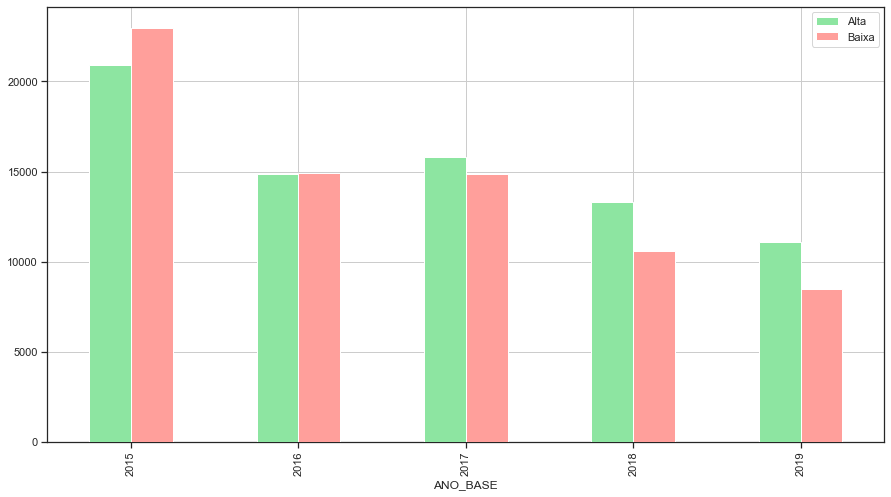

In [117]:
analise_data('ANO_BASE')

## Matriz de correlação

Para nortear o restante da análise gráfica, vamos observar a correlação com a nota da resposta ('J1')

In [118]:
corr_matrix = bd_pre.corr()

In [119]:
corr_matrix['J1'].sort_values(ascending = False)

J1          1.000000
B1_2        0.660556
B1_1        0.630125
C1_1        0.563077
E1_2        0.548510
E1_1        0.531015
C1_2        0.521092
E1_3        0.457886
A2_1        0.232853
A2_2        0.221290
D2_1        0.213154
D2_3        0.209164
A3          0.205320
F1          0.199231
F3          0.196730
A2_3        0.179820
A4          0.138530
F5          0.130805
ANO_BASE    0.077033
A5          0.072258
G1          0.048099
Q8          0.030213
Q8a         0.028441
A1_1        0.021496
I2          0.020417
D2_2        0.016938
I1          0.007834
Q5          0.005569
F2          0.001440
F6         -0.001961
D1         -0.002384
A1_4       -0.007016
H1         -0.008055
MES        -0.010961
A1_3       -0.014335
H2b        -0.030886
H2         -0.032085
F4         -0.038285
A1_2       -0.054065
PESO       -0.060375
H2a        -0.062417
IDTNS      -0.064710
H3         -0.065679
Q9         -0.067719
Name: J1, dtype: float64

In [120]:
maiores_corr = corr_matrix[corr_matrix['J1'] > 0.5]['J1'].sort_values(ascending = False).index.tolist()

In [121]:
maiores_corr.append('Resposta')
#maiores_corr.append('ESTADO')
#maiores_corr.append('OPERADORA')
maiores_corr.append('H2')

In [122]:
maiores_corr.remove('J1')

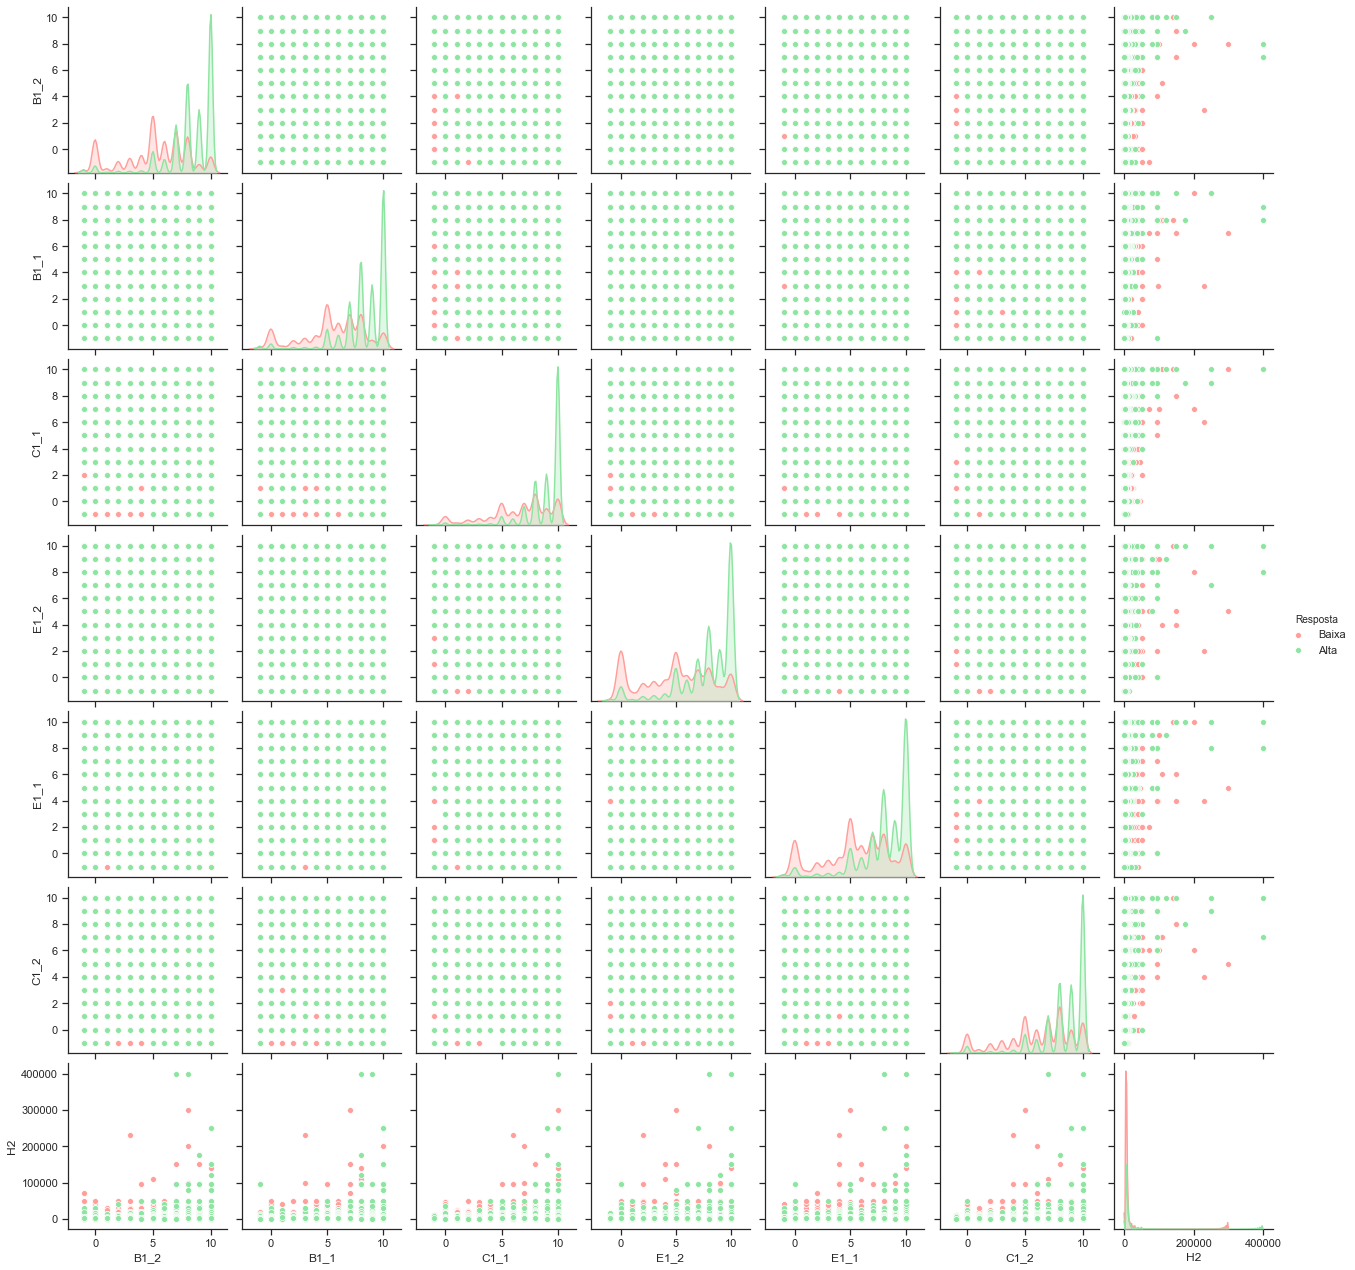

In [123]:
sns.set(style="ticks", palette="pastel")
sns.pairplot(data = bd_pre[maiores_corr], hue = 'Resposta',  palette=["r", "g"])

Pelos gráficos, a única conclusão evidente é a quantidade de respostas de renda não informada. Devido a isso, vamos olhar mais de perto esses dados.

### Renda (H2, H2a e H2b)

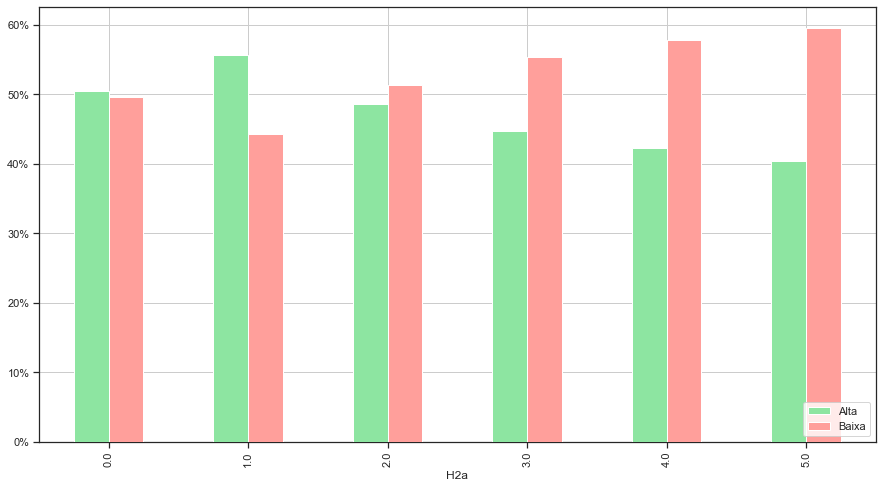

In [124]:
grafico_pct('H2a')
plt.legend(loc = 'lower right')

Aparentemente, quanto maior a faixa de renda, pior a avaliação. Além disso, aqueles que não informaram a renda avaliaram bem o serviço em sua pequena maioria. 

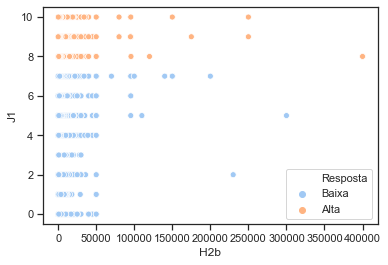

In [125]:
sns.scatterplot(data = bd_pre, x = 'H2b', y = 'J1', hue = 'Resposta')

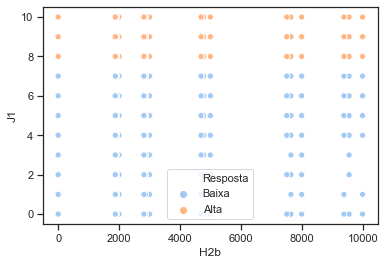

In [126]:
sns.scatterplot(data = bd_pre[bd_pre['H2'] == 0], x = 'H2b', y = 'J1', hue = 'Resposta')

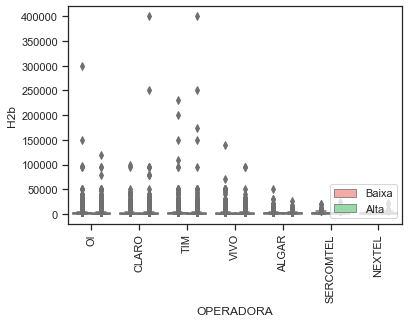

In [127]:
sns.boxplot(data = bd_pre, x = 'OPERADORA', y = 'H2b', hue = 'Resposta',  palette=["r", "g"])
plt.xticks(rotation=90)
plt.legend(loc = 'lower right')

### Comprometimento da operadora

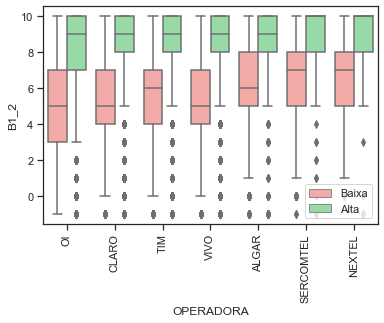

In [128]:
sns.set(style="ticks", palette="pastel")
sns.boxplot(data = bd_pre, y = 'B1_2', x = 'OPERADORA', hue = 'Resposta', palette=["r", "g"] )
plt.xticks(rotation=90)
plt.legend(loc = 'lower right')

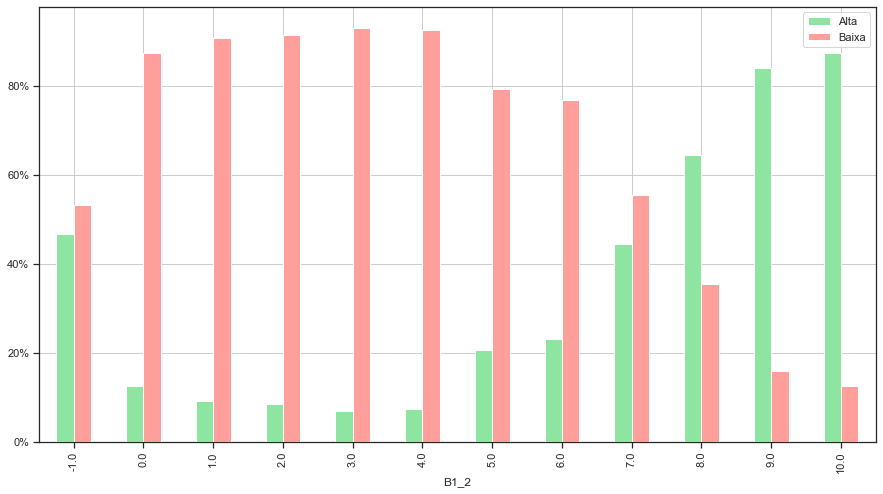

In [129]:
grafico_pct('B1_2')

Observa-se também as variáveis menos correlacionadas:

Idade do entrevistado e faixa etária vs Operadora

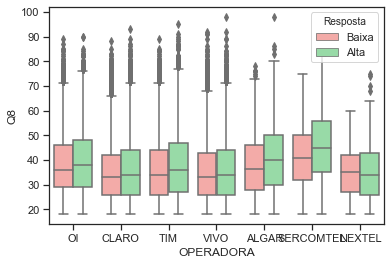

In [130]:
sns.boxplot(data = bd_pre, x = 'OPERADORA', y = 'Q8', hue = 'Resposta',  palette=["r", "g"])

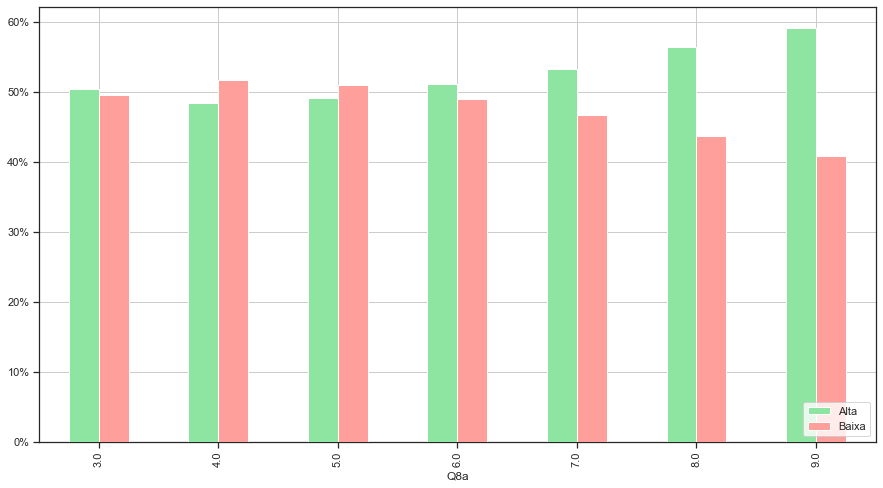

In [131]:
grafico_pct('Q8a')
plt.legend(loc = 'lower right')

Ao contrário da renda, quanto maior a idade, melhor a avaliação.

- Q9 - Sexo do entrevistado

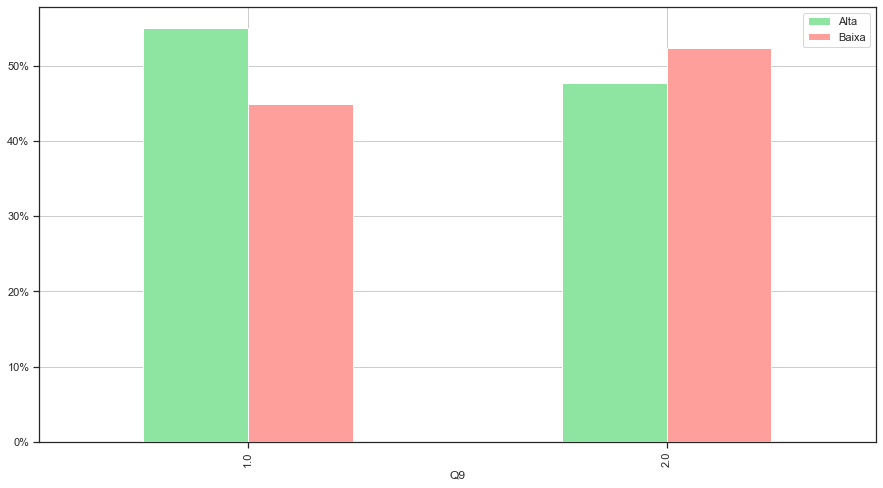

In [132]:
grafico_pct('Q9')

Apesar de a pesquisa não incluir gêneros não-binários, no geral, homens deram notas mais baixas do que mulheres.

# Arquivo de saída

Para criar e executar os modelos em R, é gerada uma base em csv:

In [133]:
bd_pre.to_csv('data/base_pre.csv', index = False)

# Conclusões

Conforme enunciado do trabalho, os dados foram tratados no Python para posterior modelagem no R:
- Para a variável resposta, J1, como apenas 0,15% eram de dados faltantes, essas linhas foram removidas da base
- Tratamento de dados faltantes foi feito tratado como não resposta em 'A1_1', 'A1_2', 'A1_3', 'A1_4'
- Respostas do Tipo 1 foram todas padronizadas pra 1: sim e 2: não
- Para facilitar a vizualização, as respostas não dadas (99) de todas as perguntas do Tipo 2 foram substituídas por -1
- Na questão Q8, valores NA foram substituídos pela média da idade de cada faixa
- Colunas com desvio padrão nulo, ou seja, que possuem apenas uma resposta e, portanto, não vão influenciar os modelos, foram removidas da base para otimizar o processamento: 'A1_2', 'Q1', 'Q2', 'Q3', 'Q4', 'Q6', 'Q7'
- Optou-se por padronizar algumas respostas realizadas em momentos diferentes e que mudam ao longo dos anos
- H2 e H2a: respostas 999997, 999998, 999999 foram substituídas por NaN; como alguns modelos não aceitam valores faltantes, todos eles foram susbtituídos por 0; além disso, cerca de 6% da base teve informação de renda preenchida pela faixa em uma nova coluna: H2b

# Referências

As principais referências utilzadas para produção deste relatório foram:

- Material de aula do curso Computação para Ciência de Dados
- [Dicas do dia](https://github.com/danielscarvalho/Insper-DS-Dicas)
- [Índice - Table of Contents](https://github.com/jupyterlab/jupyterlab-toc)
- https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-a-jupyter-jupyterlab-notebook
- [Base de dados original e documentação](http://dados.gov.br/dataset/banco-de-dados-da-pesquisa-telefonia-movel-pre-paga)
- [pandas](https://pandas.pydata.org) 
- [matplotlib](https://matplotlib.org)
- [pandas ods reader](https://github.com/iuvbio/pandas_ods_reader)
- [Portal Brasileiro de Dados Abertos - Salário Mínimo](http://www.dados.gov.br/dataset/salario-minimo/resource/8b9ccf0d-aff2-499f-8363-0fcd44ec68b3)
- [IPEADATA](http://www.ipeadata.gov.br/Default.aspx)